# AVIOS — Part 2: Machine Learning Classification Models

This notebook focuses on **automated task classification** using ML.  
We train and evaluate models (Random Forest, XGBoost, etc.) on the features collected from Linux task traces.  

Key goals:
- Replace manual classification with ML-based classification
- Compare different classifiers and select the best model per dimension
- Export trained models + encoders for later use in the AI Scheduler




In [ ]:
## LOADING DATASET

import pandas as pd

# Just update with the actual path if needed
file_path = '/content/classified_dataset.csv'

# ✅ Load the CSV
df = pd.read_csv(file_path)

# ✅ Peek into the dataset
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (3069226, 34)
Columns: ['Timestamp', 'PID', 'Name', 'Cmdline', 'PPid', 'State', 'Threads', 'Priority', 'Nice', 'Scheduling_Policy', 'CPU_Usage_%', 'Total_Time_Ticks', 'Elapsed_Time_sec', 'VmRSS', 'VmSize', 'Voluntary_ctxt_switches', 'Nonvoluntary_ctxt_switches', 'IO_Read_Bytes', 'IO_Write_Bytes', 'IO_Read_Count', 'IO_Write_Count', 'se.exec_start', 'se.vruntime', 'se.sum_exec_runtime', 'nr_switches', 'nr_voluntary_switches', 'nr_involuntary_switches', 'se.load.weight', 'avg_cpu_time', 'total_io_bytes', 'Resource_Type', 'Interactivity', 'Priority_Class', 'Execution_Time_Class']


,Timestamp,PID,Name,Cmdline,PPid,State,Threads,Priority,Nice,Scheduling_Policy,...,nr_switches,nr_voluntary_switches,nr_involuntary_switches,se.load.weight,avg_cpu_time,total_io_bytes,Resource_Type,Interactivity,Priority_Class,Execution_Time_Class
0,2025-09-08T19:15:55.317697,1,systemd,/sbin/init auto noprompt splash,-1,sleeping,1,20,0,SCHED_OTHER,...,5750.0,4654.0,1096.0,1048576.0,1.983978,395885056,IO-bound,Other,Medium,Medium
1,2025-09-08T19:15:55.317697,2,kthreadd,NaN,-1,sleeping,1,20,0,SCHED_OTHER,...,501.0,469.0,32.0,1048576.0,0.051918,0,Mixed,Other,Medium,Short
2,2025-09-08T19:15:55.317697,3,pool_workqueue_release,NaN,2,sleeping,1,20,0,SCHED_OTHER,...,6.0,6.0,0.0,1048576.0,0.000000,0,Mixed,Other,Medium,Short
3,2025-09-08T19:15:55.317697,4,kworker/R-rcu_g,NaN,2,idle,1,0,-20,SCHED_OTHER,...,2.0,2.0,0.0,90891264.0,0.000000,0,Mixed,Other,High,Short
4,2025-09-08T19:15:55.317697,5,kworker/R-rcu_p,NaN,2,idle,1,0,-20,SCHED_OTHER,...,2.0,2.0,0.0,90891264.0,0.000000,0,Mixed,Other,High,Short


In [ ]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test
train_raw, test_raw = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print("Train:", train_raw.shape)
print("Test:", test_raw.shape)

# Save for later use
train_raw.to_csv("train_raw.csv", index=False)
test_raw.to_csv("test_raw.csv", index=False)



Train: (2455380, 34)
Test: (613846, 34)


In [ ]:
## PREPROCESSING DATASET

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib

def preprocess_dataset(df):
    # 🧼 Clean & convert memory fields
    for col in ['VmRSS', 'VmSize']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace('kB', '', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # 🧼 Numeric conversions
    numeric_cols = [
        'CPU_Usage_%', 'Nice', 'Priority', 'Total_Time_Ticks', 'Elapsed_Time_sec',
        'Voluntary_ctxt_switches', 'Nonvoluntary_ctxt_switches',
        'IO_Read_Bytes', 'IO_Write_Bytes', 'IO_Read_Count', 'IO_Write_Count',
        'se.exec_start', 'se.vruntime', 'se.sum_exec_runtime',
        'nr_switches', 'nr_voluntary_switches', 'nr_involuntary_switches',
        'se.load.weight'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # ⏱ Avoid divide-by-zero
    df['Elapsed_Time_sec'] = df['Elapsed_Time_sec'].replace(0, 1e-5)

    # 🔧 Engineered features
    df['cpu_to_elapsed_ratio'] = df['CPU_Usage_%'] / df['Elapsed_Time_sec']
    df['interactivity_score'] = df['Voluntary_ctxt_switches'] / (df['Nonvoluntary_ctxt_switches'] + 1)
    df['is_sleeping'] = df['State'].astype(str).str.lower().str.contains('sleeping', na=False).astype(int)

    # 🔠 Encode categoricals
    encoders = {}
    for col in ['State', 'Scheduling_Policy']:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
            joblib.dump(le, f'le_{col.lower()}.pkl')

    # 🧹 Drop unnecessary columns
    drop_cols = ['Timestamp', 'PID', 'Name', 'PPid', 'Cmdline']
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

    return df

# ✨ Apply to train/test
train_raw = pd.read_csv('/content/train_raw.csv')
test_raw = pd.read_csv('/content/test_raw.csv')

train_processed = preprocess_dataset(train_raw)
test_processed = preprocess_dataset(test_raw)

# 💾 Save cleaned versions
train_processed.to_csv('/content/train_processed.csv', index=False)
test_processed.to_csv('/content/test_processed.csv', index=False)

print("✅ Preprocessing done! Ready for SMOTE and model training.")


✅ Preprocessing done! Ready for SMOTE and model training.


In [ ]:
df = pd.read_csv('/content/train_processed.csv')

print("\n🔸 Resource_Type distribution:\n", df['Resource_Type'].value_counts())
print("\n🔸 Interactivity distribution:\n", df['Interactivity'].value_counts())
print("\n🔸 Priority_Class distribution:\n", df['Priority_Class'].value_counts())
print("\n🔸 Execution_Time_Class distribution:\n", df['Execution_Time_Class'].value_counts())



🔸 Resource_Type distribution:
 Resource_Type
Mixed        2119003
IO-bound      329266
CPU-bound       7111
Name: count, dtype: int64

🔸 Interactivity distribution:
 Interactivity
Other          1612229
Interactive     475139
Real-time       339951
Background       21939
Batch             6122
Name: count, dtype: int64

🔸 Priority_Class distribution:
 Priority_Class
Medium    1763793
High       659828
Low         31759
Name: count, dtype: int64

🔸 Execution_Time_Class distribution:
 Execution_Time_Class
Short     2367356
Long        49526
Medium      38498
Name: count, dtype: int64


In [ ]:
## TRAINING MODELS

import pandas as pd
import joblib
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# -------------------------------
# Define features for each model
# -------------------------------
resource_feats = [
    'CPU_Usage_%', 'Threads',
    'Voluntary_ctxt_switches','Nonvoluntary_ctxt_switches',
    'IO_Read_Bytes','IO_Write_Bytes','IO_Read_Count','IO_Write_Count',
    'se.sum_exec_runtime'
]

interactivity_feats = [
    'Scheduling_Policy','Nice','CPU_Usage_%','Total_Time_Ticks',
    'Voluntary_ctxt_switches','Nonvoluntary_ctxt_switches',
    'Elapsed_Time_sec','State',
    'interactivity_score','is_sleeping'
]

priority_feats = [
    'Priority','Nice','se.load.weight','Threads'
]

execution_feats = [
    'Total_Time_Ticks','Elapsed_Time_sec','se.sum_exec_runtime','avg_cpu_time'
]

# Save for reference
json.dump(resource_feats, open("resource_features.json","w"))
json.dump(interactivity_feats, open("interactivity_features.json","w"))
json.dump(priority_feats, open("priority_features.json","w"))
json.dump(execution_feats, open("execution_features.json","w"))

# -------------------------------
# Training function
# -------------------------------
def train_and_save_models(df_path, features, label_col, model_name):
    print(f"\n🔹 Training models for: {label_col}")
    df = pd.read_csv(df_path)

    X = df[features]
    y = df[label_col]

    # --- Label Encoder for XGBoost ---
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    joblib.dump(le, f"le_{model_name}.pkl")  # save for decoding later

    # --- Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )
    rf.fit(X, y)
    rf_preds = rf.predict(X)
    print(f"✅ RF Accuracy: {accuracy_score(y, rf_preds):.4f}")
    print("RandomForest Report:\n", classification_report(y, rf_preds))
    joblib.dump(rf, f"{model_name}_rf.pkl")

    # --- XGBoost (GPU enabled) ---
    xgb = XGBClassifier(
        n_estimators=500,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="gpu_hist",   # 🚀 Use GPU
        predictor="gpu_predictor",
        objective="multi:softmax",
        num_class=len(le.classes_),
        random_state=42,
        n_jobs=-1,
        eval_metric="mlogloss"
    )
    xgb.fit(X, y_encoded)
    xgb_preds = le.inverse_transform(xgb.predict(X))
    print(f"✅ XGB Accuracy: {accuracy_score(y, xgb_preds):.4f}")
    print("XGBoost Report:\n", classification_report(y, xgb_preds))
    joblib.dump(xgb, f"{model_name}_xgb.pkl")

    print(f"💾 Models saved: {model_name}_rf.pkl, {model_name}_xgb.pkl")
    return rf, xgb

# -------------------------------
# Train each model
# -------------------------------
rf_resource_model, xgb_resource_model     = train_and_save_models("train_processed.csv", resource_feats, 'Resource_Type', 'resource_model')
rf_inter_model, xgb_inter_model           = train_and_save_models("train_processed.csv", interactivity_feats, 'Interactivity', 'interactivity_model')
rf_priority_model, xgb_priority_model     = train_and_save_models("train_processed.csv", priority_feats, 'Priority_Class', 'priority_model')
rf_execution_model, xgb_execution_model   = train_and_save_models("train_processed.csv", execution_feats, 'Execution_Time_Class', 'execution_model')



🔹 Training models for: Resource_Type
✅ RF Accuracy: 1.0000
RandomForest Report:
               precision    recall  f1-score   support

   CPU-bound       1.00      1.00      1.00      7111
    IO-bound       1.00      1.00      1.00    329266
       Mixed       1.00      1.00      1.00   2119003

    accuracy                           1.00   2455380
   macro avg       1.00      1.00      1.00   2455380
weighted avg       1.00      1.00      1.00   2455380



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:33:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:33:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [04:33:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: Use

✅ XGB Accuracy: 1.0000
XGBoost Report:
               precision    recall  f1-score   support

   CPU-bound       1.00      1.00      1.00      7111
    IO-bound       1.00      1.00      1.00    329266
       Mixed       1.00      1.00      1.00   2119003

    accuracy                           1.00   2455380
   macro avg       1.00      1.00      1.00   2455380
weighted avg       1.00      1.00      1.00   2455380

💾 Models saved: resource_model_rf.pkl, resource_model_xgb.pkl

🔹 Training models for: Interactivity
✅ RF Accuracy: 0.9614
RandomForest Report:
               precision    recall  f1-score   support

  Background       1.00      1.00      1.00     21939
       Batch       1.00      1.00      1.00      6122
 Interactive       0.84      0.99      0.91    475139
       Other       1.00      0.94      0.97   1612229
   Real-time       1.00      1.00      1.00    339951

    accuracy                           0.96   2455380
   macro avg       0.97      0.99      0.98   2455380
w

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:56:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:56:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [04:57:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


✅ XGB Accuracy: 0.9986
XGBoost Report:
               precision    recall  f1-score   support

  Background       1.00      1.00      1.00     21939
       Batch       1.00      1.00      1.00      6122
 Interactive       1.00      1.00      1.00    475139
       Other       1.00      1.00      1.00   1612229
   Real-time       1.00      1.00      1.00    339951

    accuracy                           1.00   2455380
   macro avg       1.00      1.00      1.00   2455380
weighted avg       1.00      1.00      1.00   2455380

💾 Models saved: interactivity_model_rf.pkl, interactivity_model_xgb.pkl

🔹 Training models for: Priority_Class
✅ RF Accuracy: 1.0000
RandomForest Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00    659828
         Low       1.00      1.00      1.00     31759
      Medium       1.00      1.00      1.00   1763793

    accuracy                           1.00   2455380
   macro avg       1.00      1.00      1.00 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:00:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:00:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [05:01:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


✅ XGB Accuracy: 1.0000
XGBoost Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00    659828
         Low       1.00      1.00      1.00     31759
      Medium       1.00      1.00      1.00   1763793

    accuracy                           1.00   2455380
   macro avg       1.00      1.00      1.00   2455380
weighted avg       1.00      1.00      1.00   2455380

💾 Models saved: priority_model_rf.pkl, priority_model_xgb.pkl

🔹 Training models for: Execution_Time_Class
✅ RF Accuracy: 1.0000
RandomForest Report:
               precision    recall  f1-score   support

        Long       1.00      1.00      1.00     49526
      Medium       1.00      1.00      1.00     38498
       Short       1.00      1.00      1.00   2367356

    accuracy                           1.00   2455380
   macro avg       1.00      1.00      1.00   2455380
weighted avg       1.00      1.00      1.00   2455380



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:08:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:08:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [05:09:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


✅ XGB Accuracy: 0.9997
XGBoost Report:
               precision    recall  f1-score   support

        Long       1.00      1.00      1.00     49526
      Medium       0.99      0.99      0.99     38498
       Short       1.00      1.00      1.00   2367356

    accuracy                           1.00   2455380
   macro avg       1.00      1.00      1.00   2455380
weighted avg       1.00      1.00      1.00   2455380

💾 Models saved: execution_model_rf.pkl, execution_model_xgb.pkl


In [ ]:
# -------------------------------
# Evaluate all models on test set
# -------------------------------
import os

test_df = pd.read_csv("/content/test_processed.csv")

def evaluate_model(model_path, encoder_path, features, label_col):
    print(f"\n📊 Evaluating {model_path} on {label_col}")
    model = joblib.load(model_path)

    X_test = test_df[features]
    y_test = test_df[label_col]

    if "xgb" in model_path:
        # XGB needs encoded labels
        le = joblib.load(encoder_path)
        y_test_enc = le.transform(y_test)

        preds_enc = model.predict(X_test)
        preds = le.inverse_transform(preds_enc)

    else:
        # RF works with raw labels
        preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    print(f"✅ Test Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, preds))


# Evaluate all 8 models
evaluate_model("resource_model_rf.pkl", "le_resource_model.pkl", resource_feats, "Resource_Type")
evaluate_model("resource_model_xgb.pkl", "le_resource_model.pkl", resource_feats, "Resource_Type")

evaluate_model("interactivity_model_rf.pkl", "le_interactivity_model.pkl", interactivity_feats, "Interactivity")
evaluate_model("interactivity_model_xgb.pkl", "le_interactivity_model.pkl", interactivity_feats, "Interactivity")

evaluate_model("priority_model_rf.pkl", "le_priority_model.pkl", priority_feats, "Priority_Class")
evaluate_model("priority_model_xgb.pkl", "le_priority_model.pkl", priority_feats, "Priority_Class")

evaluate_model("execution_model_rf.pkl", "le_execution_model.pkl", execution_feats, "Execution_Time_Class")
evaluate_model("execution_model_xgb.pkl", "le_execution_model.pkl", execution_feats, "Execution_Time_Class")



📊 Evaluating resource_model_rf.pkl on Resource_Type
✅ Test Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

   CPU-bound       1.00      1.00      1.00      1803
    IO-bound       1.00      1.00      1.00     82324
       Mixed       1.00      1.00      1.00    529719

    accuracy                           1.00    613846
   macro avg       1.00      1.00      1.00    613846
weighted avg       1.00      1.00      1.00    613846


📊 Evaluating resource_model_xgb.pkl on Resource_Type


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [05:11:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


✅ Test Accuracy: 0.9999
Classification Report:
               precision    recall  f1-score   support

   CPU-bound       0.99      0.99      0.99      1803
    IO-bound       1.00      1.00      1.00     82324
       Mixed       1.00      1.00      1.00    529719

    accuracy                           1.00    613846
   macro avg       1.00      1.00      1.00    613846
weighted avg       1.00      1.00      1.00    613846


📊 Evaluating interactivity_model_rf.pkl on Interactivity
✅ Test Accuracy: 0.9614
Classification Report:
               precision    recall  f1-score   support

  Background       1.00      1.00      1.00      5529
       Batch       1.00      1.00      1.00      1553
 Interactive       0.84      0.99      0.91    119622
       Other       1.00      0.94      0.97    402367
   Real-time       1.00      1.00      1.00     84775

    accuracy                           0.96    613846
   macro avg       0.97      0.99      0.98    613846
weighted avg       0.97      0.

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [05:12:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


✅ Test Accuracy: 0.9981
Classification Report:
               precision    recall  f1-score   support

  Background       1.00      1.00      1.00      5529
       Batch       0.99      0.99      0.99      1553
 Interactive       1.00      1.00      1.00    119622
       Other       1.00      1.00      1.00    402367
   Real-time       1.00      1.00      1.00     84775

    accuracy                           1.00    613846
   macro avg       1.00      1.00      1.00    613846
weighted avg       1.00      1.00      1.00    613846


📊 Evaluating priority_model_rf.pkl on Priority_Class
✅ Test Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00    164928
         Low       1.00      1.00      1.00      7951
      Medium       1.00      1.00      1.00    440967

    accuracy                           1.00    613846
   macro avg       1.00      1.00      1.00    613846
weighted avg       1.00      1.00  

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [05:12:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


✅ Test Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00    164928
         Low       1.00      1.00      1.00      7951
      Medium       1.00      1.00      1.00    440967

    accuracy                           1.00    613846
   macro avg       1.00      1.00      1.00    613846
weighted avg       1.00      1.00      1.00    613846


📊 Evaluating execution_model_rf.pkl on Execution_Time_Class
✅ Test Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

        Long       1.00      1.00      1.00     12356
      Medium       1.00      1.00      1.00      9510
       Short       1.00      1.00      1.00    591980

    accuracy                           1.00    613846
   macro avg       1.00      1.00      1.00    613846
weighted avg       1.00      1.00      1.00    613846


📊 Evaluating execution_model_xgb.pkl on Execution_Time_Class


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [05:12:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


✅ Test Accuracy: 0.9996
Classification Report:
               precision    recall  f1-score   support

        Long       1.00      1.00      1.00     12356
      Medium       0.99      0.99      0.99      9510
       Short       1.00      1.00      1.00    591980

    accuracy                           1.00    613846
   macro avg       1.00      1.00      1.00    613846
weighted avg       1.00      1.00      1.00    613846




🌟 Top 10 features for resource_model_rf.pkl:
IO_Read_Bytes: 0.2976
CPU_Usage_%: 0.2906
se.sum_exec_runtime: 0.1940
Nonvoluntary_ctxt_switches: 0.0946
Voluntary_ctxt_switches: 0.0490
IO_Read_Count: 0.0230
IO_Write_Count: 0.0218
IO_Write_Bytes: 0.0206
Threads: 0.0087


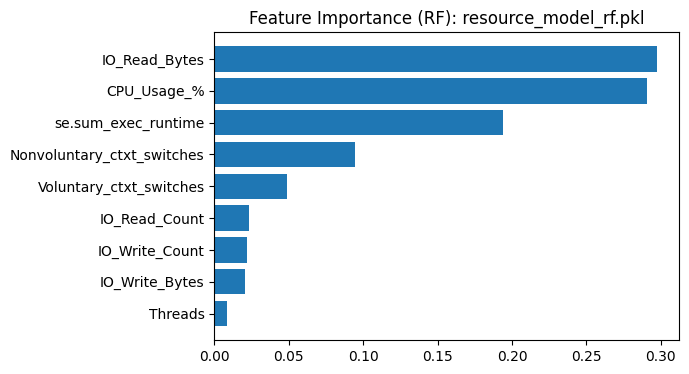


🌟 Top features for resource_model_xgb.pkl:


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:91: UserWarning: [05:23:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  importance = booster.get_booster().get_score(


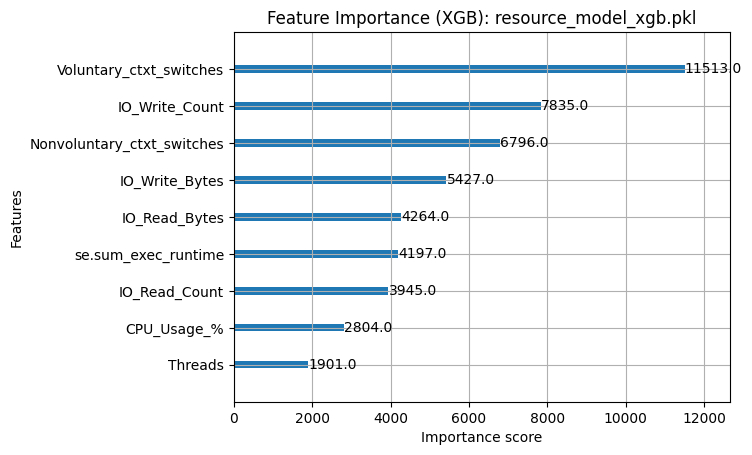


🌟 Top 10 features for interactivity_model_rf.pkl:
Nice: 0.2205
Scheduling_Policy: 0.2118
CPU_Usage_%: 0.1279
Total_Time_Ticks: 0.1255
Nonvoluntary_ctxt_switches: 0.0896
interactivity_score: 0.0866
Voluntary_ctxt_switches: 0.0597
State: 0.0338
Elapsed_Time_sec: 0.0239
is_sleeping: 0.0207


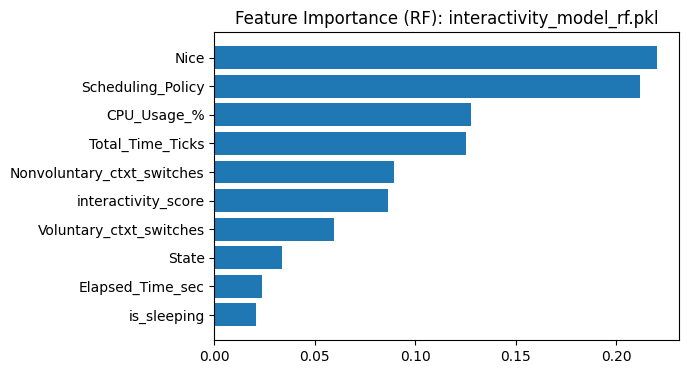


🌟 Top features for interactivity_model_xgb.pkl:


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:91: UserWarning: [05:23:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  importance = booster.get_booster().get_score(


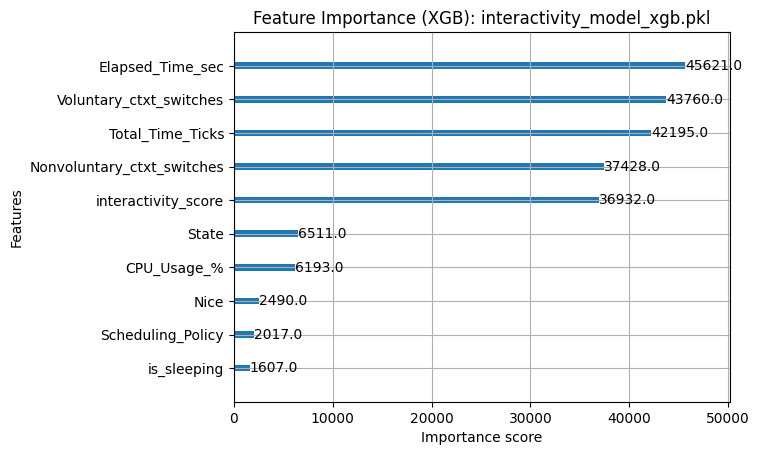


🌟 Top 10 features for priority_model_rf.pkl:
Nice: 0.3913
se.load.weight: 0.3580
Priority: 0.2507
Threads: 0.0000


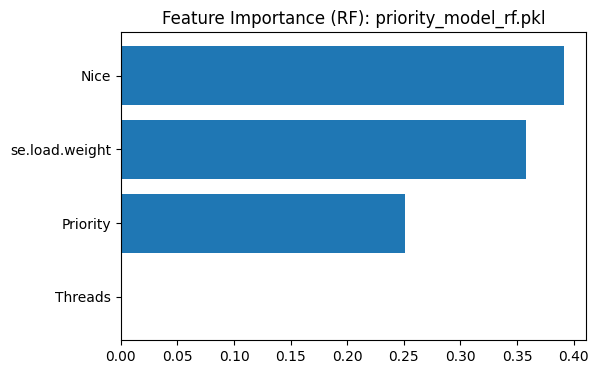


🌟 Top features for priority_model_xgb.pkl:


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:91: UserWarning: [05:23:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  importance = booster.get_booster().get_score(


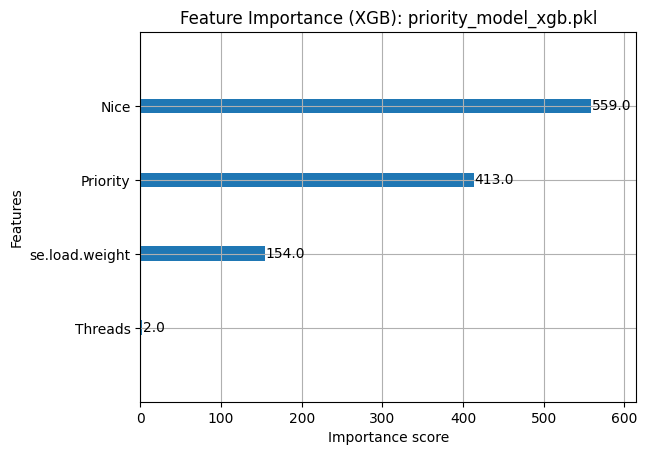


🌟 Top 10 features for execution_model_rf.pkl:
Total_Time_Ticks: 0.6287
se.sum_exec_runtime: 0.1984
avg_cpu_time: 0.1686
Elapsed_Time_sec: 0.0043


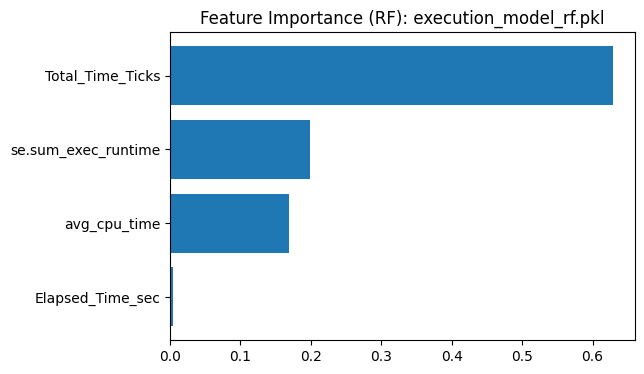


🌟 Top features for execution_model_xgb.pkl:


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:91: UserWarning: [05:23:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  importance = booster.get_booster().get_score(


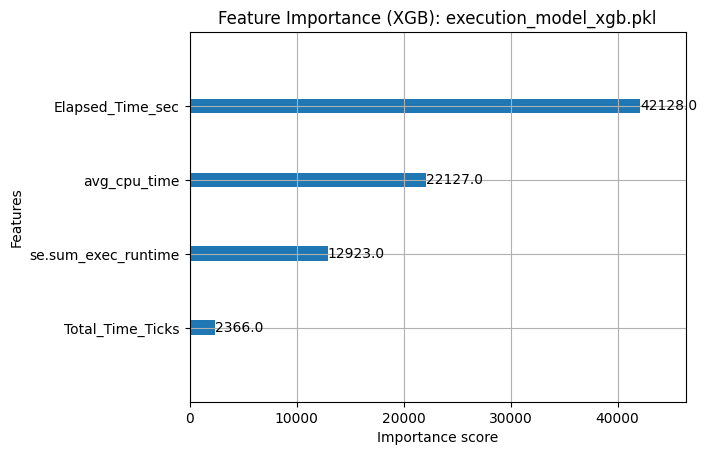

In [ ]:
# -------------------------------
# 🔹 Feature Importance (RF + XGB)
# -------------------------------
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

def plot_feature_importance(model_path, features, top_n=10):
    model = joblib.load(model_path)

    if "rf" in model_path:  # RandomForest
        importances = model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]

        print(f"\n🌟 Top {top_n} features for {model_path}:")
        for idx in sorted_idx[:top_n]:
            print(f"{features[idx]}: {importances[idx]:.4f}")

        plt.figure(figsize=(6,4))
        plt.barh([features[i] for i in sorted_idx[:top_n]][::-1],
                 importances[sorted_idx[:top_n]][::-1])
        plt.title(f"Feature Importance (RF): {model_path}")
        plt.show()

    elif "xgb" in model_path:  # XGBoost
        print(f"\n🌟 Top features for {model_path}:")
        xgb_model = model
        xgb.plot_importance(xgb_model, importance_type="weight", max_num_features=top_n)
        plt.title(f"Feature Importance (XGB): {model_path}")
        plt.show()


# Run for all models
plot_feature_importance("resource_model_rf.pkl", resource_feats)
plot_feature_importance("resource_model_xgb.pkl", resource_feats)

plot_feature_importance("interactivity_model_rf.pkl", interactivity_feats)
plot_feature_importance("interactivity_model_xgb.pkl", interactivity_feats)

plot_feature_importance("priority_model_rf.pkl", priority_feats)
plot_feature_importance("priority_model_xgb.pkl", priority_feats)

plot_feature_importance("execution_model_rf.pkl", execution_feats)
plot_feature_importance("execution_model_xgb.pkl", execution_feats)



🔹 Cross-validation for: Resource_Type


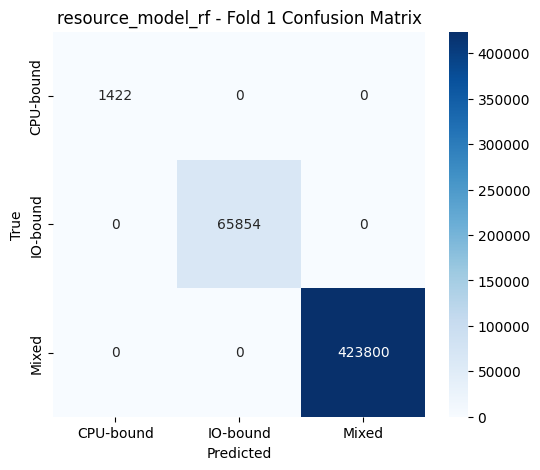

Fold 1 Accuracy: 1.0000


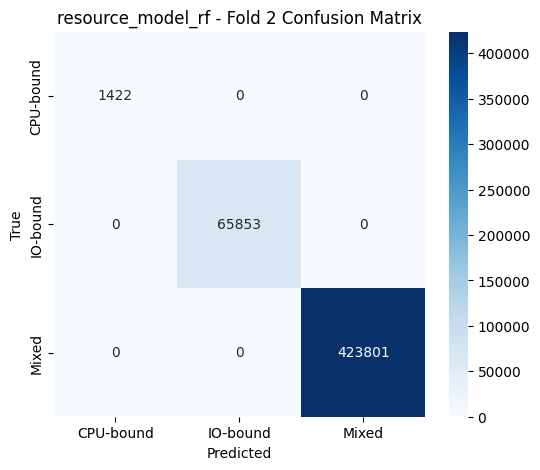

Fold 2 Accuracy: 1.0000


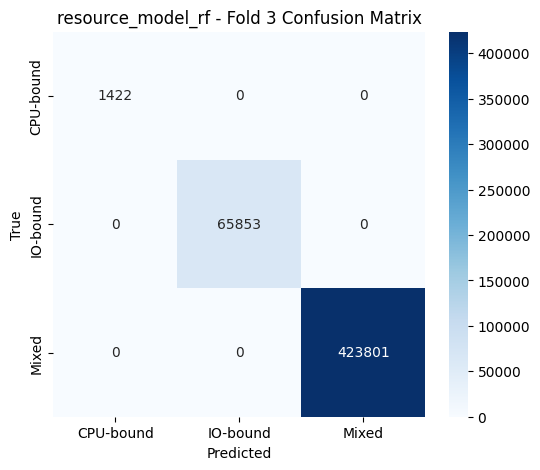

Fold 3 Accuracy: 1.0000


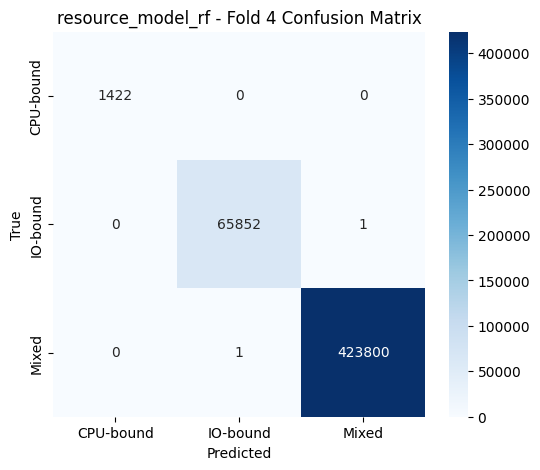

Fold 4 Accuracy: 1.0000


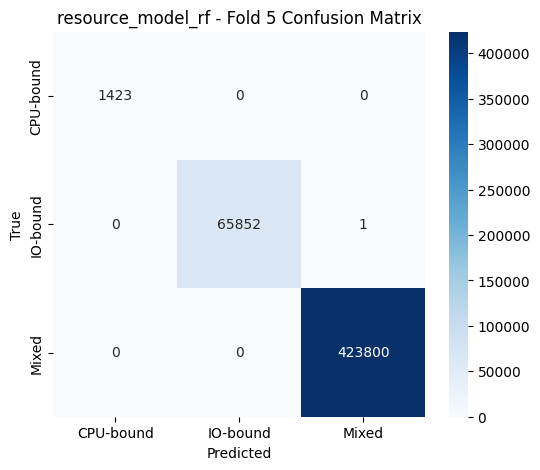

Fold 5 Accuracy: 1.0000

📌 resource_model_rf | Mean CV Accuracy: 1.0000 ± 0.0000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:16:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:16:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [07:17:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


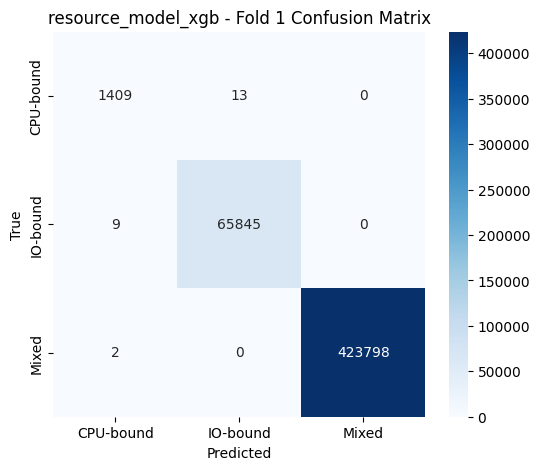

Fold 1 Accuracy: 1.0000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:17:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:17:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [07:17:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


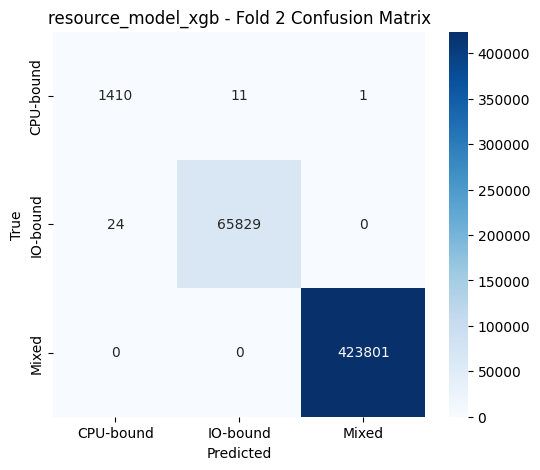

Fold 2 Accuracy: 0.9999


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:17:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:17:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [07:17:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


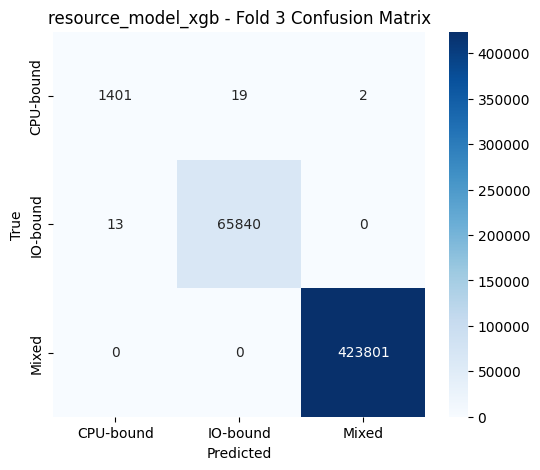

Fold 3 Accuracy: 0.9999


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:18:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:18:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [07:18:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


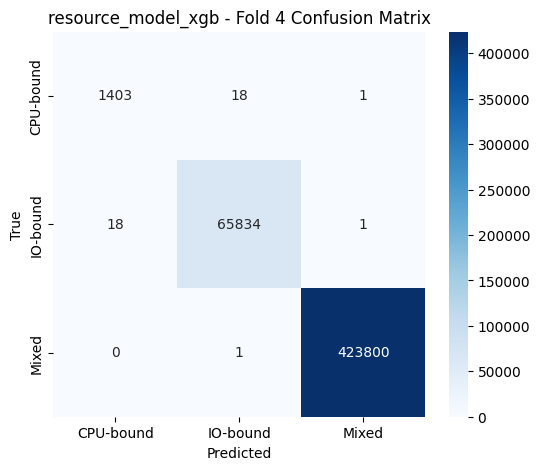

Fold 4 Accuracy: 0.9999


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:18:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:18:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [07:18:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


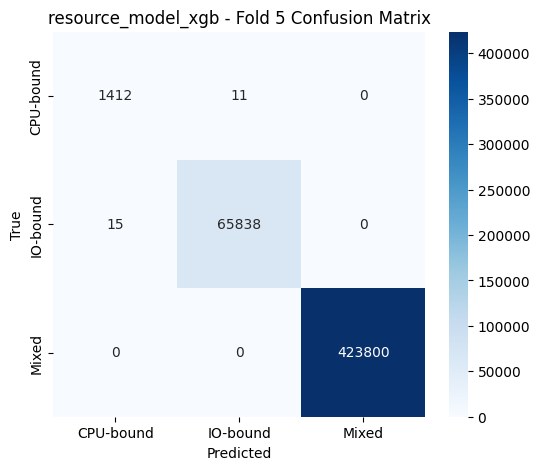

Fold 5 Accuracy: 0.9999

📌 resource_model_xgb | Mean CV Accuracy: 0.9999 ± 0.0000

🔹 Cross-validation for: Interactivity


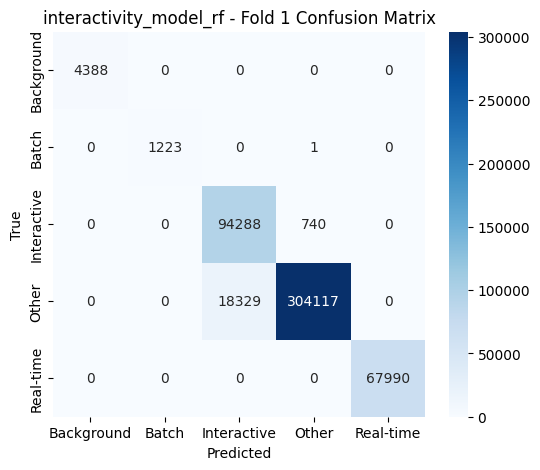

Fold 1 Accuracy: 0.9612


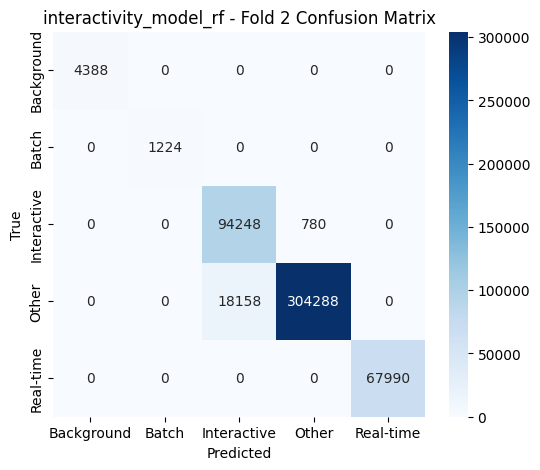

Fold 2 Accuracy: 0.9614


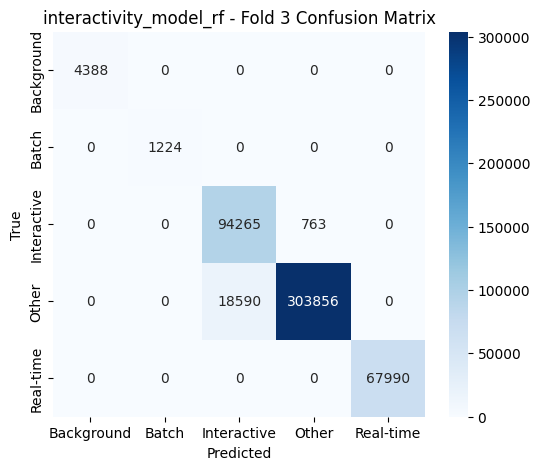

Fold 3 Accuracy: 0.9606


In [ ]:
# -------------------------------
# 🔄 Cross-Validation with Confusion Matrices
# -------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cross_validate_with_confusion(model, X, y, model_name, use_label_encoder=False):
    acc_scores = []
    fold = 1

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        if use_label_encoder:
            le = LabelEncoder()
            y_train_enc = le.fit_transform(y_train)
            y_val_enc = le.transform(y_val)

            model.fit(X_train, y_train_enc)
            preds_enc = model.predict(X_val)
            preds = le.inverse_transform(preds_enc)
        else:
            model.fit(X_train, y_train)
            preds = model.predict(X_val)

        acc = accuracy_score(y_val, preds)
        acc_scores.append(acc)

        # Confusion matrix
        cm = confusion_matrix(y_val, preds, labels=np.unique(y))
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.title(f"{model_name} - Fold {fold} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        print(f"Fold {fold} Accuracy: {acc:.4f}")
        fold += 1

    print(f"\n📌 {model_name} | Mean CV Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
    return acc_scores

# Reload processed training data
train_df = pd.read_csv("train_processed.csv")

tasks = [
    ("Resource_Type", resource_feats, "resource_model"),
    ("Interactivity", interactivity_feats, "interactivity_model"),
    ("Priority_Class", priority_feats, "priority_model"),
    ("Execution_Time_Class", execution_feats, "execution_model"),
]

for label_col, features, model_name in tasks:
    print(f"\n🔹 Cross-validation for: {label_col}")
    X = train_df[features]
    y = train_df[label_col]

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )
    cross_validate_with_confusion(rf, X, y, f"{model_name}_rf")

    # XGBoost (GPU)
    le = LabelEncoder()
    y_enc = le.fit_transform(y)  # encode once for XGB
    xgb = XGBClassifier(
        n_estimators=500,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="gpu_hist",    # 🚀 GPU enabled
        predictor="gpu_predictor",
        objective="multi:softmax",
        num_class=len(le.classes_),
        random_state=42,
        n_jobs=-1,
        eval_metric="mlogloss"
    )
    cross_validate_with_confusion(xgb, X, y, f"{model_name}_xgb", use_label_encoder=True)
